<a href="https://colab.research.google.com/github/ThisIsFarhan/LangGraph-Practice/blob/main/13_Time_Travel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_groq langgraph_sdk

In [2]:
from google.colab import userdata
from langchain_groq import ChatGroq

groq_api_key=userdata.get('groq_api_key')
llm=ChatGroq(groq_api_key=groq_api_key,model_name="Gemma2-9b-It")

In [3]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm_with_tools = llm.bind_tools(tools)

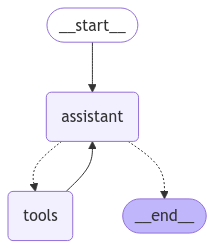

In [5]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [6]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_sg95)
 Call ID: call_sg95
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

6


In [7]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='80ced19d-ec1f-46f9-9c62-3f236c8f84d5'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_sg95', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 85, 'prompt_tokens': 1277, 'total_tokens': 1362, 'completion_time': 0.154545455, 'prompt_time': 0.052620427, 'queue_time': 0.02467200900000001, 'total_time': 0.207165882}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-fb4b0d77-ff5f-4dbc-ac61-040a4a7a8933-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_sg95', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1277, 'output_tokens': 85, 'total_tokens': 1362}), ToolMessage(content='6', name='multiply', id='92b6d459-f2de-4103-ba96-169db2a97025', tool_cal

In [8]:
all_states = [s for s in graph.get_state_history(thread)]

In [9]:
len(all_states)

5

In [17]:
all_states[-1]

StateSnapshot(values={'messages': []}, next=('__start__',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efdfc3c-00ab-6c80-bfff-fdc6d1cc79ad'}}, metadata={'source': 'input', 'writes': {'__start__': {'messages': HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={})}}, 'thread_id': '1', 'step': -1, 'parents': {}}, created_at='2025-01-31T11:08:50.532027+00:00', parent_config=None, tasks=(PregelTask(id='e391fbcf-c0a6-3e6c-0966-7bfc8204f3b9', name='__start__', path=('__pregel_pull', '__start__'), error=None, interrupts=(), state=None, result={'messages': HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={})}),))

In [18]:
to_replay = all_states[-2]

In [19]:
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='80ced19d-ec1f-46f9-9c62-3f236c8f84d5')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efdfc3c-00d7-6ca5-8000-96d504153415'}}, metadata={'source': 'loop', 'writes': None, 'thread_id': '1', 'step': 0, 'parents': {}}, created_at='2025-01-31T11:08:50.550034+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efdfc3c-00ab-6c80-bfff-fdc6d1cc79ad'}}, tasks=(PregelTask(id='6374a966-b58c-cb9c-1984-3951e2462686', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_sg95', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 85, 'prompt_tokens': 1277, 't

In [20]:
to_replay.values

{'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='80ced19d-ec1f-46f9-9c62-3f236c8f84d5')]}

In [21]:
to_replay.next

('assistant',)

In [22]:
to_replay.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efdfc3c-00d7-6ca5-8000-96d504153415'}}

In [23]:
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_byx5)
 Call ID: call_byx5
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

6


In [24]:
to_fork = all_states[-2]
to_fork.values["messages"]

[HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='80ced19d-ec1f-46f9-9c62-3f236c8f84d5')]

In [25]:
to_fork.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efdfc3c-00d7-6ca5-8000-96d504153415'}}

In [26]:
fork_config = graph.update_state(
    to_fork.config,
    {"messages": [HumanMessage(content='Multiply 5 and 3',
                               id=to_fork.values["messages"][0].id)]},
)

In [27]:
fork_config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efdfc48-ca0f-667d-8001-6deaa79f64c0'}}

In [28]:
all_states = [state for state in graph.get_state_history(thread) ]
all_states[0].values["messages"]

[HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='80ced19d-ec1f-46f9-9c62-3f236c8f84d5')]

In [29]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='80ced19d-ec1f-46f9-9c62-3f236c8f84d5')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efdfc48-ca0f-667d-8001-6deaa79f64c0'}}, metadata={'source': 'update', 'writes': {'__start__': {'messages': [HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='80ced19d-ec1f-46f9-9c62-3f236c8f84d5')]}}, 'thread_id': '1', 'step': 1, 'parents': {}, 'checkpoint_ns': '', 'checkpoint_id': '1efdfc3c-00d7-6ca5-8000-96d504153415'}, created_at='2025-01-31T11:14:33.771746+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efdfc3c-00d7-6ca5-8000-96d504153415'}}, tasks=(PregelTask(id='1ca55769-c1a4-47bc-fd33-12d43872694e', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),))

In [30]:
for event in graph.stream(None, fork_config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 5 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_23fm)
 Call ID: call_23fm
  Args:
    a: 5
    b: 3
================================= Tool Message =================================
Name: multiply

15
================================== Ai Message ==================================

15


In [31]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='80ced19d-ec1f-46f9-9c62-3f236c8f84d5'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_23fm', 'function': {'arguments': '{"a":5,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 85, 'prompt_tokens': 1277, 'total_tokens': 1362, 'completion_time': 0.154545455, 'prompt_time': 0.052258741, 'queue_time': 0.024857194, 'total_time': 0.206804196}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-c68e9506-1a22-40bd-9c4e-c3a72633fb78-0', tool_calls=[{'name': 'multiply', 'args': {'a': 5, 'b': 3}, 'id': 'call_23fm', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1277, 'output_tokens': 85, 'total_tokens': 1362}), ToolMessage(content='15', name='multiply', id='b5974918-f36e-4f52-9df9-97c8174418a8', tool_call_id='c

In [32]:
all_states = [s for s in graph.get_state_history(thread)]

In [33]:
len(all_states)

12